In [ ]:
# Generate synthetic 2-ball elastic collision videos for training data.

!pip install -q timm einops av opencv-python-headless

import os
import cv2
import numpy as np
from pathlib import Path

SEED = 42
np.random.seed(SEED)

DATA_ROOT = Path("/content/physion_data")
LATENT_ROOT = Path("/content/latents")
SYNTH_DIR = DATA_ROOT / "synthetic_collisions"

for folder in [DATA_ROOT, LATENT_ROOT, SYNTH_DIR]:
    folder.mkdir(parents=True, exist_ok=True)

def generate_collision_video(video_id, n_frames=150, size=256):
    """Generate a 2-ball elastic collision video."""
    frames = []

    x1, y1 = 64.0, 128.0
    x2, y2 = 192.0, 128.0
    vx1, vy1 = 2.0 + np.random.rand(), (np.random.rand() - 0.5) * 2
    vx2, vy2 = -2.0 - np.random.rand(), (np.random.rand() - 0.5) * 2

    radius = 20

    for _ in range(n_frames):
        frame = np.zeros((size, size, 3), dtype=np.uint8)
        cv2.circle(frame, (int(x1), int(y1)), radius, (255, 255, 0), -1)
        cv2.circle(frame, (int(x2), int(y2)), radius, (0, 0, 255), -1)
        frames.append(frame)

        x1 += vx1; y1 += vy1
        x2 += vx2; y2 += vy2

        # Wall collisions
        if x1 < radius or x1 > size - radius: vx1 *= -1
        if y1 < radius or y1 > size - radius: vy1 *= -1
        if x2 < radius or x2 > size - radius: vx2 *= -1
        if y2 < radius or y2 > size - radius: vy2 *= -1

        # Ball-to-ball elastic collision
        dx, dy = x2 - x1, y2 - y1
        dist = np.sqrt(dx**2 + dy**2)
        if dist < 2 * radius and dist > 0:
            nx, ny = dx / dist, dy / dist
            dvx, dvy = vx1 - vx2, vy1 - vy2
            dvn = dvx * nx + dvy * ny
            vx1 -= dvn * nx; vy1 -= dvn * ny
            vx2 += dvn * nx; vy2 += dvn * ny
            # Separate overlapping balls
            overlap = 2 * radius - dist
            x1 -= overlap * nx / 2; y1 -= overlap * ny / 2
            x2 += overlap * nx / 2; y2 += overlap * ny / 2

    path = SYNTH_DIR / f"collision_{video_id:04d}.mp4"
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(path), fourcc, 30, (size, size))
    for frame in frames:
        out.write(frame)
    out.release()
    return str(path)

num_videos = 50
print(f"Generating {num_videos} synthetic physics videos...")
video_files = [generate_collision_video(i) for i in range(num_videos)]
print(f"Generated {num_videos} videos in: {SYNTH_DIR}")

CONFIG = {
    "data_root": str(DATA_ROOT),
    "video_dir": str(SYNTH_DIR),
    "latent_dir": str(LATENT_ROOT),
    "video_files": video_files,
    "window_size": 16,
    "stride": 1,
    "latent_dim": 1024,
    "q_dim": 512,
    "p_dim": 512,
    "batch_size": 32,
    "num_epochs": 50,
}

print(f"Video count: {len(CONFIG['video_files'])}")
print(f"Sample path: {CONFIG['video_files'][0]}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 62.9 MB/s eta 0:00:00
Generating 50 synthetic physics videos...
Generated 50 videos in: /content/physion_data/synthetic_collisions
Video count: 50
Sample path: /content/physion_data/synthetic_collisions/collision_0000.mp4


In [ ]:
# Extract V-JEPA 2 latents and build sliding windows.

!pip install -q torchcodec

import torch
from torchcodec.decoders import VideoDecoder
from transformers import AutoVideoProcessor, AutoModel

print("Loading V-JEPA 2 ViT-L model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

MODEL_NAME = "facebook/vjepa2-vitl-fpc16-256-ssv2"
processor = AutoVideoProcessor.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    attn_implementation="sdpa"
).to(device)
model.eval()

print(f"Model loaded: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M params, "
      f"{torch.cuda.memory_allocated() / 1e9:.2f}GB VRAM")

@torch.no_grad()
def extract_clip_latents(video_path, clip_size=16, stride=4):
    """Extract per-clip latents with V-JEPA 2.
    stride=4 subsamples clips for speed; the windowing stride below is 1.
    """
    vr = VideoDecoder(video_path)
    total_frames = vr.metadata.num_frames

    if total_frames < clip_size:
        return None

    all_latents = []
    for start_idx in range(0, total_frames - clip_size + 1, stride):
        frame_indices = np.arange(start_idx, start_idx + clip_size)
        video = vr.get_frames_at(indices=frame_indices).data

        inputs = processor(video, return_tensors="pt")
        inputs = {k: v.to(device, dtype=torch.float16) if v.dtype == torch.float32 else v.to(device)
                  for k, v in inputs.items()}

        outputs = model(**inputs)
        latent = outputs.last_hidden_state.mean(dim=1)
        all_latents.append(latent.cpu().float())

    return torch.cat(all_latents, dim=0)


def create_windows(latents, window_size=16, stride=1):
    """[T, D] -> [num_windows, window_size, D] sliding windows."""
    T, D = latents.shape
    num_windows = (T - window_size) // stride + 1
    if num_windows <= 0:
        return None
    windows = []
    for i in range(num_windows):
        start = i * stride
        windows.append(latents[start:start + window_size])
    return torch.stack(windows, dim=0)


print(f"\nExtracting latents from {len(CONFIG['video_files'])} videos...")

latent_dir = Path(CONFIG['latent_dir'])
latent_dir.mkdir(exist_ok=True)

total_windows = 0
successful = 0

for idx, video_path in enumerate(CONFIG['video_files']):
    video_name = Path(video_path).stem
    output_path = latent_dir / f"{video_name}_latents.pt"

    if output_path.exists():
        print(f"[{idx+1}/{len(CONFIG['video_files'])}] Skipping {video_name} (exists)")
        data = torch.load(output_path)
        total_windows += data.shape[0]
        successful += 1
        continue

    print(f"[{idx+1}/{len(CONFIG['video_files'])}] Processing {video_name}...", end=" ")
    clip_latents = extract_clip_latents(video_path, clip_size=16, stride=4)

    if clip_latents is None or len(clip_latents) < CONFIG['window_size']:
        print("SKIPPED (too short)")
        continue

    windows = create_windows(clip_latents, window_size=CONFIG['window_size'], stride=CONFIG['stride'])
    if windows is None:
        print("SKIPPED (insufficient windows)")
        continue

    torch.save(windows, output_path)
    total_windows += windows.shape[0]
    successful += 1
    print(f"{windows.shape[0]} windows")

print(f"\nExtraction complete: {successful}/{len(CONFIG['video_files'])} videos, {total_windows} windows")

del model, processor
torch.cuda.empty_cache()
import gc
gc.collect()

if torch.cuda.is_available():
    print(f"CUDA memory: {torch.cuda.memory_allocated() / 1e9:.2f}GB allocated")

latent_files = list(latent_dir.glob("*_latents.pt"))
CONFIG['latent_files'] = [str(f) for f in latent_files]
print(f"{len(latent_files)} latent files ready.")

Loading V-JEPA 2 ViT-L model...
Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


video_preprocessor_config.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/587 [00:00<?, ?it/s]

VJEPA2Model LOAD REPORT from: facebook/vjepa2-vitl-fpc16-256-ssv2
Key                                                              | Status     |  | 
-----------------------------------------------------------------+------------+--+-
pooler.self_attention_layers.{0, 1, 2}.mlp.fc2.bias              | UNEXPECTED |  | 
pooler.cross_attention_layer.cross_attn.k_proj.bias              | UNEXPECTED |  | 
pooler.cross_attention_layer.mlp.fc2.bias                        | UNEXPECTED |  | 
pooler.self_attention_layers.{0, 1, 2}.self_attn.q_proj.weight   | UNEXPECTED |  | 
pooler.self_attention_layers.{0, 1, 2}.mlp.fc1.bias              | UNEXPECTED |  | 
pooler.self_attention_layers.{0, 1, 2}.layer_norm2.bias          | UNEXPECTED |  | 
classifier.bias                                                  | UNEXPECTED |  | 
pooler.self_attention_layers.{0, 1, 2}.self_attn.v_proj.bias     | UNEXPECTED |  | 
pooler.cross_attention_layer.cross_attn.q_proj.bias              | UNEXPECTED |  | 
pooler.sel

Model loaded: 326.0M params, 0.65GB VRAM

Extracting latents from 50 videos...
[1/50] Processing collision_0000... 19 windows
[2/50] Processing collision_0001... 19 windows
[3/50] Processing collision_0002... 19 windows
[4/50] Processing collision_0003... 19 windows
[5/50] Processing collision_0004... 19 windows
[6/50] Processing collision_0005... 19 windows
[7/50] Processing collision_0006... 19 windows
[8/50] Processing collision_0007... 19 windows
[9/50] Processing collision_0008... 19 windows
[10/50] Processing collision_0009... 19 windows
[11/50] Processing collision_0010... 19 windows
[12/50] Processing collision_0011... 19 windows
[13/50] Processing collision_0012... 19 windows
[14/50] Processing collision_0013... 19 windows
[15/50] Processing collision_0014... 19 windows
[16/50] Processing collision_0015... 19 windows
[17/50] Processing collision_0016... 19 windows
[18/50] Processing collision_0017... 19 windows
[19/50] Processing collision_0018... 19 windows
[20/50] Processing

In [ ]:
# HNN and integrators.

import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


class LatentHNN(nn.Module):
    """MLP: (q, p) -> scalar H.
    z in R^1024 splits into q (coords) and p (momenta), each R^512.
    """

    def __init__(self, latent_dim=1024, hidden_dims=[512, 512, 256]):
        super().__init__()
        self.latent_dim = latent_dim
        self.q_dim = latent_dim // 2
        self.p_dim = latent_dim // 2

        layers = []
        in_dim = latent_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.Softplus(beta=1.0))  # C-inf, needed for Hamilton's eqs
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)
        self._init_weights()

    def _init_weights(self):
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=0.5)
                nn.init.zeros_(m.bias)

    def forward(self, z):
        return self.net(z)

    def split_state(self, z):
        return z[..., :self.q_dim], z[..., self.q_dim:]

    def merge_state(self, q, p):
        return torch.cat([q, p], dim=-1)

    def time_derivative(self, z):
        """dq/dt = dH/dp, dp/dt = -dH/dq."""
        z = z.requires_grad_(True)
        H = self.forward(z)

        dH_dz = torch.autograd.grad(
            H.sum(), z, create_graph=True, retain_graph=True
        )[0]

        dH_dq = dH_dz[..., :self.q_dim]
        dH_dp = dH_dz[..., self.q_dim:]

        dq_dt = dH_dp       # dq/dt =  dH/dp
        dp_dt = -dH_dq      # dp/dt = -dH/dq

        return self.merge_state(dq_dt, dp_dt)


class SymplecticIntegrator(nn.Module):
    """Stormer-Verlet (leapfrog) integrator. Second-order symplectic."""

    def __init__(self, hnn, dt=1.0):
        super().__init__()
        self.hnn = hnn
        self.dt = nn.Parameter(torch.tensor(dt), requires_grad=True)
        self.q_dim = hnn.q_dim

    def _compute_gradients(self, q, p):
        z = self.hnn.merge_state(q, p)
        z = z.requires_grad_(True)
        H = self.hnn(z)
        dH_dz = torch.autograd.grad(
            H.sum(), z, create_graph=True, retain_graph=True
        )[0]
        return dH_dz[..., :self.q_dim], dH_dz[..., self.q_dim:]

    def step(self, z):
        q, p = self.hnn.split_state(z)
        dt = torch.clamp(self.dt, 0.1, 2.0)

        # Half-step momentum
        dH_dq, _ = self._compute_gradients(q, p)
        p_half = p - (dt / 2) * dH_dq

        # Full-step position
        _, dH_dp = self._compute_gradients(q, p_half)
        q_next = q + dt * dH_dp

        # Half-step momentum
        dH_dq_next, _ = self._compute_gradients(q_next, p_half)
        p_next = p_half - (dt / 2) * dH_dq_next

        return self.hnn.merge_state(q_next, p_next)

    def rollout(self, z0, n_steps):
        trajectory = [z0]
        z = z0
        for _ in range(n_steps):
            z = self.step(z)
            trajectory.append(z)
        return torch.stack(trajectory, dim=1)


class EulerIntegrator(nn.Module):
    """Forward Euler (non-symplectic). Ablation baseline."""
    def __init__(self, hnn, dt=1.0):
        super().__init__()
        self.hnn = hnn
        self.dt = nn.Parameter(torch.tensor(dt), requires_grad=True)

    def step(self, z):
        dt = torch.clamp(self.dt, 0.1, 2.0)
        dz_dt = self.hnn.time_derivative(z)
        return z + dt * dz_dt

    def rollout(self, z0, n_steps):
        trajectory = [z0]
        z = z0
        for _ in range(n_steps):
            z = self.step(z)
            trajectory.append(z)
        return torch.stack(trajectory, dim=1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hnn = LatentHNN(
    latent_dim=CONFIG['latent_dim'],
    hidden_dims=[512, 512, 256]
).to(device)

integrator = SymplecticIntegrator(hnn, dt=1.0).to(device)

print(f"LatentHNN: {sum(p.numel() for p in hnn.parameters()) / 1e6:.2f}M parameters")
print(f"Integrator dt (learnable, clamped to [0.1, 2.0]): {integrator.dt.item():.3f}")
print(f"Device: {device}")

z_test = torch.randn(4, 1024, device=device)
H_test = hnn(z_test)
print(f"\nSanity check:")
print(f"  H(z) shape: {H_test.shape}")
print(f"  dz/dt shape: {hnn.time_derivative(z_test).shape}")

z_next = integrator.step(z_test)
traj = integrator.rollout(z_test, n_steps=5)
H_traj = hnn(traj.view(-1, 1024)).view(4, 6)
energy_drift = (H_traj - H_traj[:, 0:1]).abs().mean().item()
print(f"  Rollout shape: {traj.shape}")
print(f"  Energy drift over 5 steps: {energy_drift:.6f}")

euler_test = EulerIntegrator(hnn, dt=1.0).to(device)
euler_traj = euler_test.rollout(z_test, n_steps=5)
print(f"  Euler rollout shape: {euler_traj.shape}")

LatentHNN: 0.92M parameters
Integrator dt (learnable, clamped to [0.1, 2.0]): 1.000
Device: cuda

Sanity check:
  H(z) shape: torch.Size([4, 1])
  dz/dt shape: torch.Size([4, 1024])
  Rollout shape: torch.Size([4, 6, 1024])
  Energy drift over 5 steps: 0.000000
  Euler rollout shape: torch.Size([4, 6, 1024])


In [ ]:
# Training loop. Energy loss weight (lambda_energy) ramps 0.1 -> 1.0.

from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm


class LatentTrajectoryDataset(Dataset):
    def __init__(self, latent_files):
        self.trajectories = []
        for f in latent_files:
            data = torch.load(f, weights_only=True)
            for i in range(data.shape[0]):
                self.trajectories.append(data[i])
        print(f"Loaded {len(self.trajectories)} trajectory windows")

    def __len__(self):
        return len(self.trajectories)

    def __getitem__(self, idx):
        return self.trajectories[idx]


dataset = LatentTrajectoryDataset(CONFIG['latent_files'])

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

torch.manual_seed(SEED)

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)
print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

BATCH_SIZE = CONFIG['batch_size']
NUM_EPOCHS = CONFIG['num_epochs']

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

optimizer = torch.optim.AdamW(
    list(hnn.parameters()) + [integrator.dt],
    lr=1e-3, weight_decay=1e-5
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-5)

LAMBDA_ENERGY_START = 0.1
LAMBDA_ENERGY_END = 1.0


def get_lambda_energy(epoch, num_epochs):
    progress = (epoch - 1) / max(num_epochs - 1, 1)
    return LAMBDA_ENERGY_START + progress * (LAMBDA_ENERGY_END - LAMBDA_ENERGY_START)


# Symplectic structure comes from the leapfrog integrator, not an explicit loss term.
def compute_loss(z_pred, z_target, hnn_model, lambda_energy=0.1):
    """L_pred + lambda * L_energy."""
    l_pred = F.mse_loss(z_pred, z_target)

    B, T, D = z_pred.shape
    H = hnn_model(z_pred.reshape(B * T, D)).reshape(B, T)
    l_energy = (H - H[:, 0:1]).abs().mean()

    total = l_pred + lambda_energy * l_energy
    return total, {
        'total': total.item(),
        'prediction': l_pred.item(),
        'energy': l_energy.item(),
    }


def train_epoch(epoch, log_interval=10):
    hnn.train()
    integrator.train()
    epoch_losses = {'total': [], 'prediction': [], 'energy': []}
    lambda_e = get_lambda_energy(epoch, NUM_EPOCHS)
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")

    for batch_idx, batch in enumerate(pbar):
        batch = batch.to(device)
        B, T, D = batch.shape

        z_init = batch[:, 0, :]
        z_target = batch[:, 1:, :]
        z_pred = integrator.rollout(z_init, n_steps=T-1)[:, 1:, :].contiguous()

        loss, loss_dict = compute_loss(z_pred, z_target, hnn, lambda_energy=lambda_e)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(hnn.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_([integrator.dt], max_norm=1.0)
        optimizer.step()

        for k, v in loss_dict.items():
            epoch_losses[k].append(v)

        if batch_idx % log_interval == 0:
            pbar.set_postfix({
                'loss': f"{loss_dict['total']:.4f}",
                'pred': f"{loss_dict['prediction']:.4f}",
                'energy': f"{loss_dict['energy']:.4f}",
                'dt': f"{integrator.dt.item():.3f}",
                'lam_e': f"{lambda_e:.2f}"
            })

    return {k: np.mean(v) for k, v in epoch_losses.items()}


def evaluate_model(model_or_integrator, model_type, hnn_for_energy):
    """Full test-set eval. model_type is 'hnn' (needs enable_grad) or 'baseline'."""
    model_or_integrator.eval()
    if hasattr(model_or_integrator, 'hnn'):
        model_or_integrator.hnn.eval()

    all_sample_mse = []
    all_sample_drift = []
    timestep_mse_accum = []
    timestep_energy_accum = []

    for batch in test_loader:
        batch = batch.to(device)
        B, T, D = batch.shape
        z_init = batch[:, 0, :]
        z_target = batch[:, 1:, :]

        if model_type == 'hnn':
            with torch.enable_grad():
                z_pred = model_or_integrator.rollout(
                    z_init.requires_grad_(True), n_steps=T-1
                )[:, 1:, :].contiguous()
            z_pred_detached = z_pred.detach()
        else:
            with torch.no_grad():
                z_pred = model_or_integrator.rollout(z_init, n_steps=T-1)[:, 1:, :].contiguous()
            z_pred_detached = z_pred

        per_sample = ((z_pred_detached - z_target) ** 2).mean(dim=(1, 2))
        all_sample_mse.append(per_sample.cpu())

        per_ts_mse = ((z_pred_detached - z_target) ** 2).mean(dim=(0, 2))
        timestep_mse_accum.append(per_ts_mse.cpu())

        with torch.no_grad():
            H_pred = hnn_for_energy(z_pred_detached.reshape(-1, D)).reshape(B, T-1)
            H_init = hnn_for_energy(z_init).reshape(B, 1)
            drift_per_sample = (H_pred - H_init).abs().max(dim=1).values
            all_sample_drift.append(drift_per_sample.cpu())
            timestep_energy_accum.append(H_pred.mean(dim=0).cpu())

    all_sample_mse = torch.cat(all_sample_mse)
    all_sample_drift = torch.cat(all_sample_drift)
    avg_timestep_mse = torch.stack(timestep_mse_accum).mean(dim=0)
    avg_timestep_energy = torch.stack(timestep_energy_accum).mean(dim=0)
    std_timestep_mse = torch.stack(timestep_mse_accum).std(dim=0)
    std_timestep_energy = torch.stack(timestep_energy_accum).std(dim=0)

    return {
        'mse_mean': all_sample_mse.mean().item(),
        'mse_std': all_sample_mse.std().item(),
        'drift_mean': all_sample_drift.mean().item(),
        'drift_std': all_sample_drift.std().item(),
        'per_sample_mse': all_sample_mse.numpy(),
        'per_sample_drift': all_sample_drift.numpy(),
        'per_timestep_mse_mean': avg_timestep_mse.numpy(),
        'per_timestep_mse_std': std_timestep_mse.numpy(),
        'per_timestep_energy_mean': avg_timestep_energy.numpy(),
        'per_timestep_energy_std': std_timestep_energy.numpy(),
        'n_samples': len(all_sample_mse),
    }


def evaluate():
    metrics = evaluate_model(integrator, 'hnn', hnn)
    return {'mse': metrics['mse_mean'], 'energy_drift': metrics['drift_mean']}


def dream(z_init, n_steps=20):
    """Free rollout from a single initial state."""
    hnn.eval()
    integrator.eval()
    with torch.enable_grad():
        z_in = z_init.clone().requires_grad_(True)
        trajectory = integrator.rollout(z_in, n_steps).squeeze(0)
    trajectory = trajectory.detach()
    with torch.no_grad():
        energies = hnn(trajectory).squeeze(-1)
    return trajectory, energies


print(f"Training: {NUM_EPOCHS} epochs, batch size {BATCH_SIZE}, {len(train_loader)} batches/epoch")
print(f"Energy loss curriculum: lambda_energy {LAMBDA_ENERGY_START} -> {LAMBDA_ENERGY_END}")

history = {
    'train_loss': [], 'train_pred': [], 'train_energy': [],
    'test_mse': [], 'test_energy_drift': [], 'dt': [], 'lambda_energy': []
}
best_test_mse = float('inf')

for epoch in range(1, NUM_EPOCHS + 1):
    train_losses = train_epoch(epoch)
    test_metrics = evaluate()
    scheduler.step()
    lambda_e = get_lambda_energy(epoch, NUM_EPOCHS)

    history['train_loss'].append(train_losses['total'])
    history['train_pred'].append(train_losses['prediction'])
    history['train_energy'].append(train_losses['energy'])
    history['test_mse'].append(test_metrics['mse'])
    history['test_energy_drift'].append(test_metrics['energy_drift'])
    history['dt'].append(integrator.dt.item())
    history['lambda_energy'].append(lambda_e)

    print(f"Epoch {epoch}/{NUM_EPOCHS} | "
          f"Train: {train_losses['total']:.4f} (pred {train_losses['prediction']:.4f}, energy {train_losses['energy']:.4f}) | "
          f"Test MSE: {test_metrics['mse']:.4f}, drift: {test_metrics['energy_drift']:.4f} | "
          f"dt: {integrator.dt.item():.4f}, lambda_e: {lambda_e:.2f}, lr: {scheduler.get_last_lr()[0]:.6f}")

    if test_metrics['mse'] < best_test_mse:
        best_test_mse = test_metrics['mse']
        torch.save({
            'hnn_state_dict': hnn.state_dict(),
            'integrator_state_dict': integrator.state_dict(),
            'epoch': epoch,
            'test_mse': test_metrics['mse']
        }, '/content/best_hnn_model.pt')
        print(f"  New best model saved (MSE={best_test_mse:.4f})")

print(f"\nBest test MSE: {best_test_mse:.4f}, final dt: {integrator.dt.item():.4f}")

test_sample = next(iter(test_loader))[0:1].to(device)
z_start = test_sample[:, 0, :]
dream_traj, dream_energies = dream(z_start, n_steps=20)

print(f"\nDreaming rollout (20 steps):")
print(f"  Energy t=0: {dream_energies[0].item():.4f}, t=20: {dream_energies[-1].item():.4f}")
print(f"  Energy drift: {(dream_energies[-1] - dream_energies[0]).abs().item():.6f}")
print(f"  Max deviation: {(dream_energies - dream_energies[0]).abs().max().item():.6f}")

if test_sample.shape[1] >= 21:
    gt_traj = test_sample[0, :21, :]
    print(f"  MSE vs ground truth: {F.mse_loss(dream_traj, gt_traj).item():.4f}")

DREAM_RESULTS = {
    'trajectory': dream_traj.cpu(),
    'energies': dream_energies.cpu(),
    'z_start': z_start.cpu(),
    'ground_truth': test_sample[0].cpu() if test_sample.shape[1] >= 21 else None
}
TRAINING_HISTORY = history



# Ablation training

def train_model(model_integrator, model_hnn, model_type, num_epochs, lambda_energy_fn,
                label="Model"):
    """Train an HNN-type model (integrator + HNN)."""
    opt = torch.optim.AdamW(
        list(model_hnn.parameters()) + [model_integrator.dt],
        lr=1e-3, weight_decay=1e-5
    )
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_epochs, eta_min=1e-5)

    print(f"\nTraining {label}: {num_epochs} epochs")
    for epoch in range(1, num_epochs + 1):
        model_hnn.train()
        model_integrator.train()
        epoch_loss = 0
        n_batches = 0
        lambda_e = lambda_energy_fn(epoch, num_epochs)

        for batch in train_loader:
            batch = batch.to(device)
            B, T, D = batch.shape
            z_init = batch[:, 0, :]
            z_target = batch[:, 1:, :]

            z_pred = model_integrator.rollout(z_init, n_steps=T-1)[:, 1:, :].contiguous()
            loss, _ = compute_loss(z_pred, z_target, model_hnn, lambda_energy=lambda_e)

            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_hnn.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_([model_integrator.dt], max_norm=1.0)
            opt.step()
            epoch_loss += loss.item()
            n_batches += 1

        sched.step()
        if epoch % 10 == 0 or epoch == 1:
            print(f"  [{label}] Epoch {epoch}/{num_epochs}, Loss: {epoch_loss/n_batches:.4f}, "
                  f"lambda_e: {lambda_e:.2f}, dt: {model_integrator.dt.item():.3f}")


# --- Ablation 1: leapfrog, no energy loss ---
print("\n" + "="*60)
print("ABLATION 1: HNN with leapfrog, lambda_energy=0 throughout")
print("="*60)
torch.manual_seed(SEED)
hnn_no_energy = LatentHNN(latent_dim=CONFIG['latent_dim'], hidden_dims=[512, 512, 256]).to(device)
integrator_no_energy = SymplecticIntegrator(hnn_no_energy, dt=1.0).to(device)

train_model(
    integrator_no_energy, hnn_no_energy, model_type='hnn',
    num_epochs=NUM_EPOCHS,
    lambda_energy_fn=lambda epoch, n: 0.0,
    label="HNN (no energy)"
)

# --- Ablation 2: Euler integrator ---
print("\n" + "="*60)
print("ABLATION 2: HNN with Euler integrator + energy loss")
print("="*60)
torch.manual_seed(SEED)
hnn_euler = LatentHNN(latent_dim=CONFIG['latent_dim'], hidden_dims=[512, 512, 256]).to(device)
integrator_euler = EulerIntegrator(hnn_euler, dt=1.0).to(device)

train_model(
    integrator_euler, hnn_euler, model_type='hnn',
    num_epochs=NUM_EPOCHS,
    lambda_energy_fn=get_lambda_energy,
    label="HNN (Euler)"
)

ABLATION_MODELS = {
    'hnn_no_energy': (hnn_no_energy, integrator_no_energy),
    'hnn_euler': (hnn_euler, integrator_euler),
}
print("\nAll ablation models trained.")

Loaded 950 trajectory windows
Train: 760, Test: 190
Training: 50 epochs, batch size 32, 23 batches/epoch
Energy loss curriculum: lambda_energy 0.1 -> 1.0


Epoch 1:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 1/50 | Train: 0.2680 (pred 0.2678, energy 0.0023) | Test MSE: 0.2422, drift: 0.0204 | dt: 1.0034, lambda_e: 0.10, lr: 0.000999
  New best model saved (MSE=0.2422)


Epoch 2:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 2/50 | Train: 0.2350 (pred 0.2331, energy 0.0160) | Test MSE: 0.2248, drift: 0.0176 | dt: 1.0036, lambda_e: 0.12, lr: 0.000996
  New best model saved (MSE=0.2248)


Epoch 3:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 3/50 | Train: 0.2063 (pred 0.2039, energy 0.0171) | Test MSE: 0.2043, drift: 0.0097 | dt: 1.0066, lambda_e: 0.14, lr: 0.000991
  New best model saved (MSE=0.2043)


Epoch 4:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 4/50 | Train: 0.1859 (pred 0.1843, energy 0.0100) | Test MSE: 0.1820, drift: 0.0277 | dt: 1.0114, lambda_e: 0.16, lr: 0.000984
  New best model saved (MSE=0.1820)


Epoch 5:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 5/50 | Train: 0.1736 (pred 0.1717, energy 0.0112) | Test MSE: 0.1738, drift: 0.0181 | dt: 1.0145, lambda_e: 0.17, lr: 0.000976
  New best model saved (MSE=0.1738)


Epoch 6:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 6/50 | Train: 0.1621 (pred 0.1596, energy 0.0133) | Test MSE: 0.1676, drift: 0.0253 | dt: 1.0179, lambda_e: 0.19, lr: 0.000965
  New best model saved (MSE=0.1676)


Epoch 7:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 7/50 | Train: 0.1597 (pred 0.1565, energy 0.0153) | Test MSE: 0.1636, drift: 0.0470 | dt: 1.0218, lambda_e: 0.21, lr: 0.000953
  New best model saved (MSE=0.1636)


Epoch 8:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 8/50 | Train: 0.1539 (pred 0.1504, energy 0.0154) | Test MSE: 0.1547, drift: 0.0338 | dt: 1.0274, lambda_e: 0.23, lr: 0.000939
  New best model saved (MSE=0.1547)


Epoch 9:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 9/50 | Train: 0.1472 (pred 0.1436, energy 0.0146) | Test MSE: 0.1493, drift: 0.0251 | dt: 1.0328, lambda_e: 0.25, lr: 0.000923
  New best model saved (MSE=0.1493)


Epoch 10:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 10/50 | Train: 0.1431 (pred 0.1393, energy 0.0141) | Test MSE: 0.1444, drift: 0.0174 | dt: 1.0381, lambda_e: 0.27, lr: 0.000905
  New best model saved (MSE=0.1444)


Epoch 11:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 11/50 | Train: 0.1402 (pred 0.1362, energy 0.0142) | Test MSE: 0.1413, drift: 0.0200 | dt: 1.0443, lambda_e: 0.28, lr: 0.000886
  New best model saved (MSE=0.1413)


Epoch 12:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 12/50 | Train: 0.1354 (pred 0.1315, energy 0.0130) | Test MSE: 0.1402, drift: 0.0524 | dt: 1.0502, lambda_e: 0.30, lr: 0.000866
  New best model saved (MSE=0.1402)


Epoch 13:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 13/50 | Train: 0.1360 (pred 0.1308, energy 0.0162) | Test MSE: 0.1365, drift: 0.0212 | dt: 1.0563, lambda_e: 0.32, lr: 0.000844
  New best model saved (MSE=0.1365)


Epoch 14:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 14/50 | Train: 0.1332 (pred 0.1288, energy 0.0128) | Test MSE: 0.1349, drift: 0.0223 | dt: 1.0621, lambda_e: 0.34, lr: 0.000821
  New best model saved (MSE=0.1349)


Epoch 15:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 15/50 | Train: 0.1314 (pred 0.1266, energy 0.0135) | Test MSE: 0.1350, drift: 0.0257 | dt: 1.0679, lambda_e: 0.36, lr: 0.000796


Epoch 16:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 16/50 | Train: 0.1288 (pred 0.1241, energy 0.0123) | Test MSE: 0.1298, drift: 0.0228 | dt: 1.0747, lambda_e: 0.38, lr: 0.000770
  New best model saved (MSE=0.1298)


Epoch 17:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 17/50 | Train: 0.1245 (pred 0.1201, energy 0.0111) | Test MSE: 0.1272, drift: 0.0246 | dt: 1.0801, lambda_e: 0.39, lr: 0.000743
  New best model saved (MSE=0.1272)


Epoch 18:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 18/50 | Train: 0.1250 (pred 0.1201, energy 0.0119) | Test MSE: 0.1277, drift: 0.0229 | dt: 1.0853, lambda_e: 0.41, lr: 0.000716


Epoch 19:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 19/50 | Train: 0.1218 (pred 0.1172, energy 0.0106) | Test MSE: 0.1255, drift: 0.0219 | dt: 1.0906, lambda_e: 0.43, lr: 0.000687
  New best model saved (MSE=0.1255)


Epoch 20:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 20/50 | Train: 0.1209 (pred 0.1161, energy 0.0108) | Test MSE: 0.1271, drift: 0.0313 | dt: 1.0962, lambda_e: 0.45, lr: 0.000658


Epoch 21:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 21/50 | Train: 0.1197 (pred 0.1149, energy 0.0103) | Test MSE: 0.1204, drift: 0.0212 | dt: 1.1014, lambda_e: 0.47, lr: 0.000628
  New best model saved (MSE=0.1204)


Epoch 22:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 22/50 | Train: 0.1179 (pred 0.1129, energy 0.0103) | Test MSE: 0.1202, drift: 0.0258 | dt: 1.1065, lambda_e: 0.49, lr: 0.000598
  New best model saved (MSE=0.1202)


Epoch 23:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 23/50 | Train: 0.1174 (pred 0.1126, energy 0.0095) | Test MSE: 0.1184, drift: 0.0214 | dt: 1.1116, lambda_e: 0.50, lr: 0.000567
  New best model saved (MSE=0.1184)


Epoch 24:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 24/50 | Train: 0.1158 (pred 0.1106, energy 0.0100) | Test MSE: 0.1229, drift: 0.0237 | dt: 1.1159, lambda_e: 0.52, lr: 0.000536


Epoch 25:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 25/50 | Train: 0.1171 (pred 0.1113, energy 0.0107) | Test MSE: 0.1169, drift: 0.0154 | dt: 1.1207, lambda_e: 0.54, lr: 0.000505
  New best model saved (MSE=0.1169)


Epoch 26:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 26/50 | Train: 0.1120 (pred 0.1069, energy 0.0091) | Test MSE: 0.1163, drift: 0.0181 | dt: 1.1254, lambda_e: 0.56, lr: 0.000474
  New best model saved (MSE=0.1163)


Epoch 27:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 27/50 | Train: 0.1120 (pred 0.1066, energy 0.0093) | Test MSE: 0.1133, drift: 0.0241 | dt: 1.1300, lambda_e: 0.58, lr: 0.000443
  New best model saved (MSE=0.1133)


Epoch 28:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 28/50 | Train: 0.1101 (pred 0.1046, energy 0.0091) | Test MSE: 0.1156, drift: 0.0256 | dt: 1.1338, lambda_e: 0.60, lr: 0.000412


Epoch 29:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 29/50 | Train: 0.1111 (pred 0.1060, energy 0.0083) | Test MSE: 0.1110, drift: 0.0173 | dt: 1.1378, lambda_e: 0.61, lr: 0.000382
  New best model saved (MSE=0.1110)


Epoch 30:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 30/50 | Train: 0.1086 (pred 0.1035, energy 0.0081) | Test MSE: 0.1143, drift: 0.0144 | dt: 1.1411, lambda_e: 0.63, lr: 0.000352


Epoch 31:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 31/50 | Train: 0.1095 (pred 0.1038, energy 0.0089) | Test MSE: 0.1114, drift: 0.0165 | dt: 1.1441, lambda_e: 0.65, lr: 0.000323


Epoch 32:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 32/50 | Train: 0.1076 (pred 0.1022, energy 0.0080) | Test MSE: 0.1101, drift: 0.0156 | dt: 1.1474, lambda_e: 0.67, lr: 0.000294
  New best model saved (MSE=0.1101)


Epoch 33:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 33/50 | Train: 0.1079 (pred 0.1026, energy 0.0077) | Test MSE: 0.1075, drift: 0.0182 | dt: 1.1504, lambda_e: 0.69, lr: 0.000267
  New best model saved (MSE=0.1075)


Epoch 34:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 34/50 | Train: 0.1061 (pred 0.1007, energy 0.0075) | Test MSE: 0.1078, drift: 0.0133 | dt: 1.1529, lambda_e: 0.71, lr: 0.000240


Epoch 35:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 35/50 | Train: 0.1043 (pred 0.0997, energy 0.0064) | Test MSE: 0.1065, drift: 0.0161 | dt: 1.1550, lambda_e: 0.72, lr: 0.000214
  New best model saved (MSE=0.1065)


Epoch 36:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 36/50 | Train: 0.1039 (pred 0.0985, energy 0.0073) | Test MSE: 0.1073, drift: 0.0166 | dt: 1.1568, lambda_e: 0.74, lr: 0.000189


Epoch 37:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 37/50 | Train: 0.1047 (pred 0.0985, energy 0.0081) | Test MSE: 0.1060, drift: 0.0116 | dt: 1.1589, lambda_e: 0.76, lr: 0.000166
  New best model saved (MSE=0.1060)


Epoch 38:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 38/50 | Train: 0.1022 (pred 0.0974, energy 0.0063) | Test MSE: 0.1054, drift: 0.0107 | dt: 1.1605, lambda_e: 0.78, lr: 0.000144
  New best model saved (MSE=0.1054)


Epoch 39:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 39/50 | Train: 0.1011 (pred 0.0967, energy 0.0055) | Test MSE: 0.1042, drift: 0.0124 | dt: 1.1620, lambda_e: 0.80, lr: 0.000124
  New best model saved (MSE=0.1042)


Epoch 40:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 40/50 | Train: 0.1000 (pred 0.0956, energy 0.0054) | Test MSE: 0.1042, drift: 0.0133 | dt: 1.1629, lambda_e: 0.82, lr: 0.000105
  New best model saved (MSE=0.1042)


Epoch 41:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 41/50 | Train: 0.0998 (pred 0.0955, energy 0.0052) | Test MSE: 0.1035, drift: 0.0122 | dt: 1.1639, lambda_e: 0.83, lr: 0.000087
  New best model saved (MSE=0.1035)


Epoch 42:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 42/50 | Train: 0.0996 (pred 0.0953, energy 0.0051) | Test MSE: 0.1036, drift: 0.0120 | dt: 1.1646, lambda_e: 0.85, lr: 0.000071


Epoch 43:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 43/50 | Train: 0.0992 (pred 0.0952, energy 0.0046) | Test MSE: 0.1026, drift: 0.0114 | dt: 1.1653, lambda_e: 0.87, lr: 0.000057
  New best model saved (MSE=0.1026)


Epoch 44:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 44/50 | Train: 0.0984 (pred 0.0946, energy 0.0042) | Test MSE: 0.1025, drift: 0.0114 | dt: 1.1657, lambda_e: 0.89, lr: 0.000045
  New best model saved (MSE=0.1025)


Epoch 45:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 45/50 | Train: 0.0982 (pred 0.0946, energy 0.0040) | Test MSE: 0.1024, drift: 0.0120 | dt: 1.1661, lambda_e: 0.91, lr: 0.000034
  New best model saved (MSE=0.1024)


Epoch 46:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 46/50 | Train: 0.0978 (pred 0.0941, energy 0.0041) | Test MSE: 0.1024, drift: 0.0113 | dt: 1.1663, lambda_e: 0.93, lr: 0.000026
  New best model saved (MSE=0.1024)


Epoch 47:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 47/50 | Train: 0.0975 (pred 0.0939, energy 0.0038) | Test MSE: 0.1021, drift: 0.0095 | dt: 1.1665, lambda_e: 0.94, lr: 0.000019
  New best model saved (MSE=0.1021)


Epoch 48:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 48/50 | Train: 0.0970 (pred 0.0937, energy 0.0034) | Test MSE: 0.1018, drift: 0.0101 | dt: 1.1667, lambda_e: 0.96, lr: 0.000014
  New best model saved (MSE=0.1018)


Epoch 49:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 49/50 | Train: 0.0968 (pred 0.0934, energy 0.0034) | Test MSE: 0.1018, drift: 0.0103 | dt: 1.1668, lambda_e: 0.98, lr: 0.000011
  New best model saved (MSE=0.1018)


Epoch 50:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 50/50 | Train: 0.0967 (pred 0.0935, energy 0.0033) | Test MSE: 0.1018, drift: 0.0102 | dt: 1.1669, lambda_e: 1.00, lr: 0.000010
  New best model saved (MSE=0.1018)

Best test MSE: 0.1018, final dt: 1.1669

Dreaming rollout (20 steps):
  Energy t=0: -3.5574, t=20: -3.5684
  Energy drift: 0.011003
  Max deviation: 0.018646

ABLATION 1: HNN with leapfrog, lambda_energy=0 throughout

Training HNN (no energy): 50 epochs
  [HNN (no energy)] Epoch 1/50, Loss: 0.2646, lambda_e: 0.00, dt: 1.000
  [HNN (no energy)] Epoch 10/50, Loss: 0.1326, lambda_e: 0.00, dt: 1.008
  [HNN (no energy)] Epoch 20/50, Loss: 0.1048, lambda_e: 0.00, dt: 1.014
  [HNN (no energy)] Epoch 30/50, Loss: 0.0894, lambda_e: 0.00, dt: 1.017
  [HNN (no energy)] Epoch 40/50, Loss: 0.0816, lambda_e: 0.00, dt: 1.019
  [HNN (no energy)] Epoch 50/50, Loss: 0.0787, lambda_e: 0.00, dt: 1.020

ABLATION 2: HNN with Euler integrator + energy loss

Training HNN (Euler): 50 epochs
  [HNN (Euler)] Epoch 1/50, Loss: 0.2661, lambda_e: 

Training baseline MLP with MULTI-STEP rollout loss (50 epochs)...
  Optimizer: AdamW (lr=1e-3, wd=1e-5), cosine scheduler, grad clip 1.0
  Epoch 1/50, Loss: 3548.6249
  Epoch 10/50, Loss: 9.7181
  Epoch 20/50, Loss: 0.2732
  Epoch 30/50, Loss: 0.2220
  Epoch 40/50, Loss: 0.2116
  Epoch 50/50, Loss: 0.1977

Collapse detection (mean step size in latent space):
  HNN (leapfrog):  2.0263
  Baseline MLP:    0.2806

Evaluating all models on full test set...
  Evaluated over 190 test windows

Timing inference (15-step rollout)...
  HNN (leapfrog): 40.99 +/- 2.43 ms (2.73 ms/step)
  HNN (Euler):    14.31 +/- 0.97 ms (0.95 ms/step)
  Baseline MLP:   2.22 +/- 0.22 ms (0.15 ms/step)
  HNN/Baseline ratio: 18.5x
  Note: HNN requires torch.enable_grad() at inference (autograd for Hamilton's eqs)

Plot 1: Energy conservation...


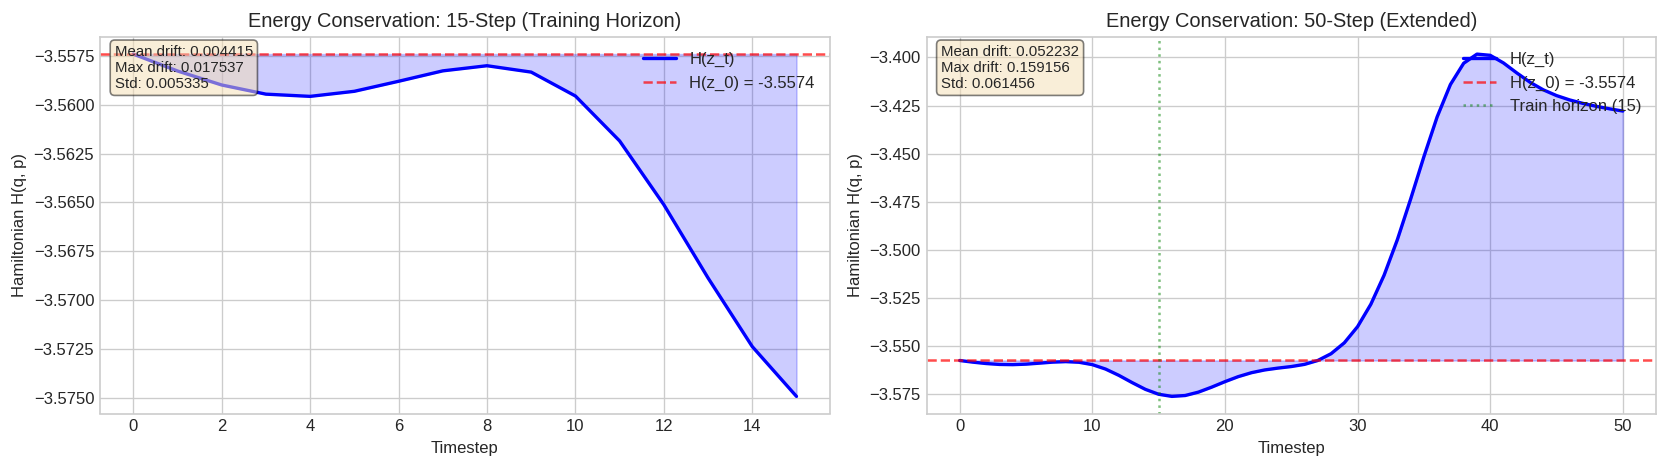

Plot 2: Phase portrait...


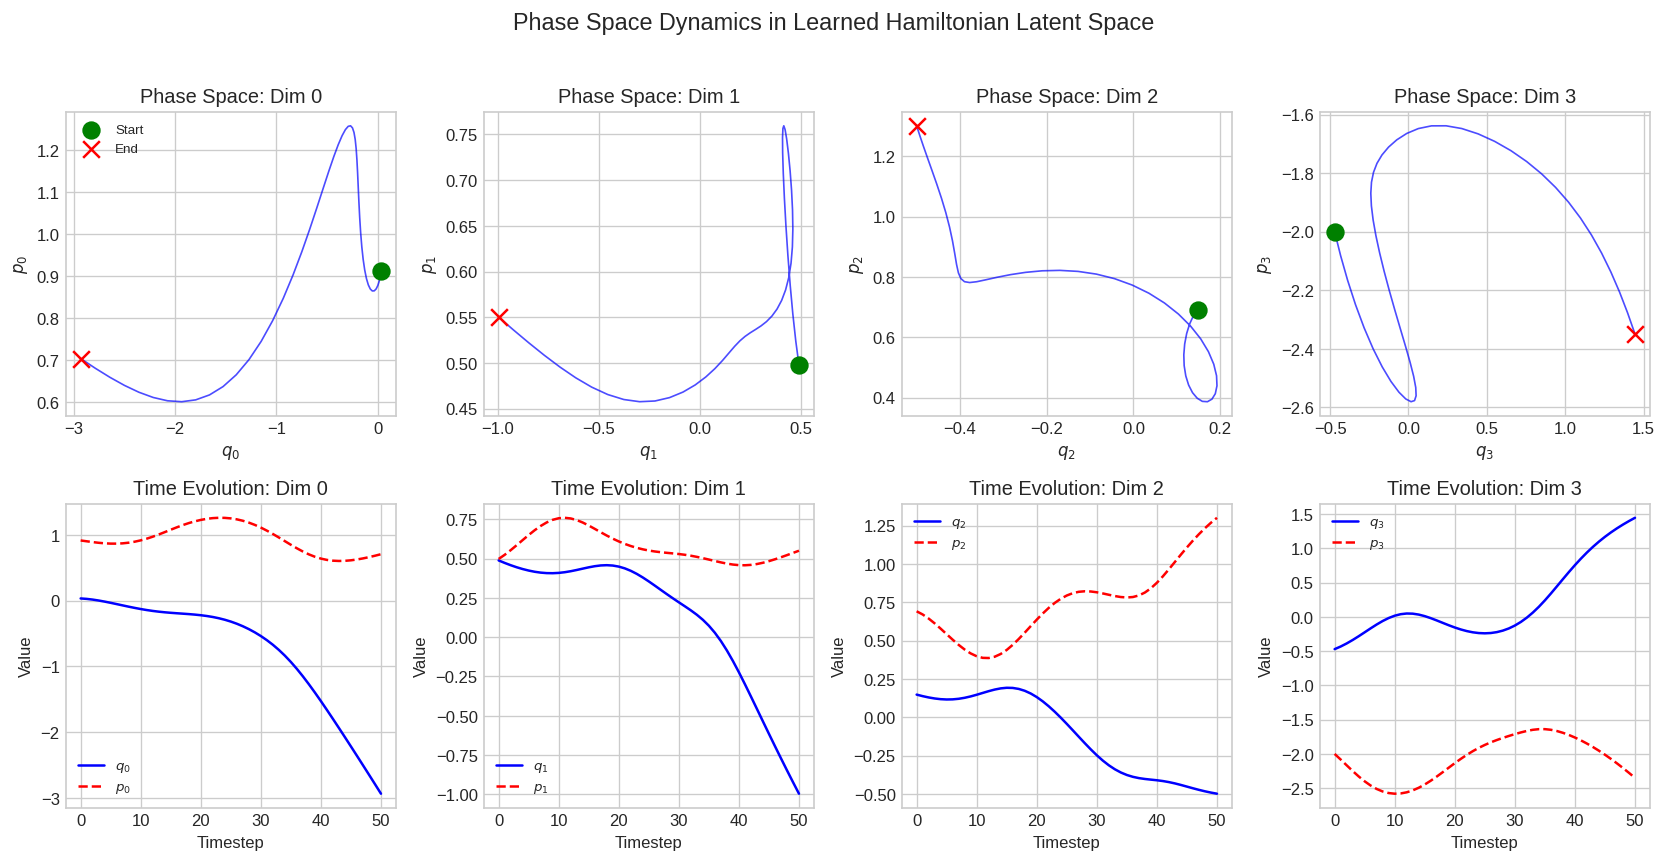

Plot 3: HNN vs baseline (with error bars over test set)...


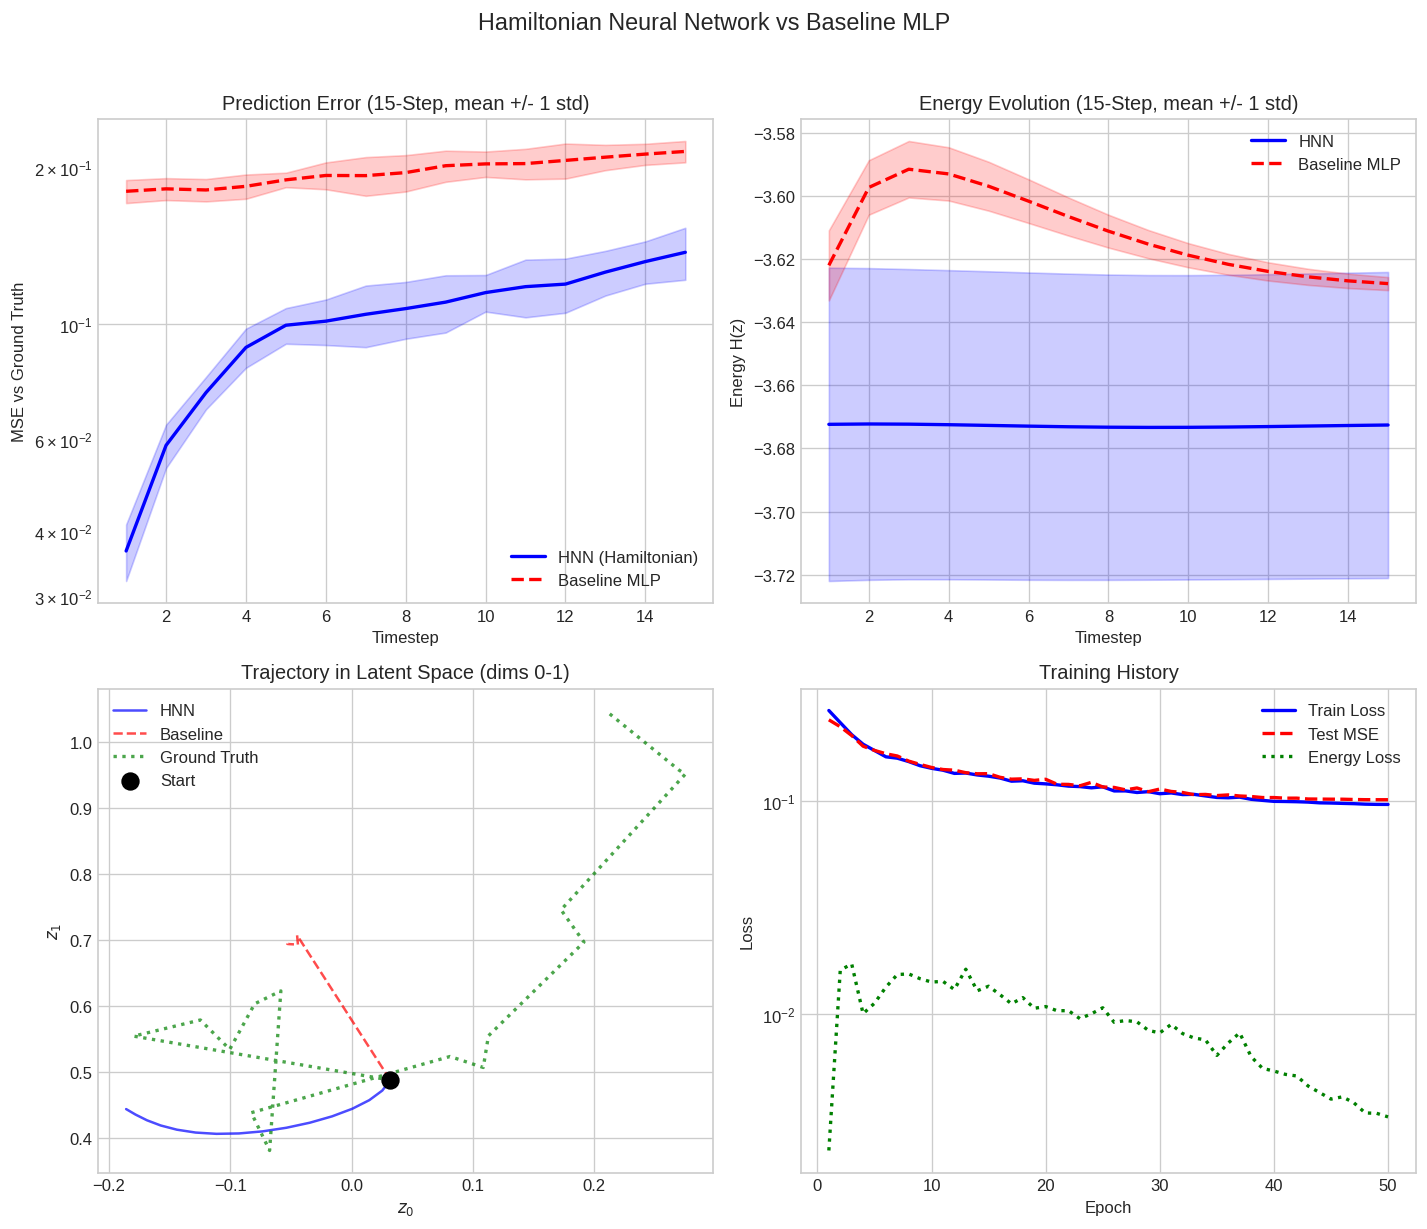

Plot 4: Ablation study...


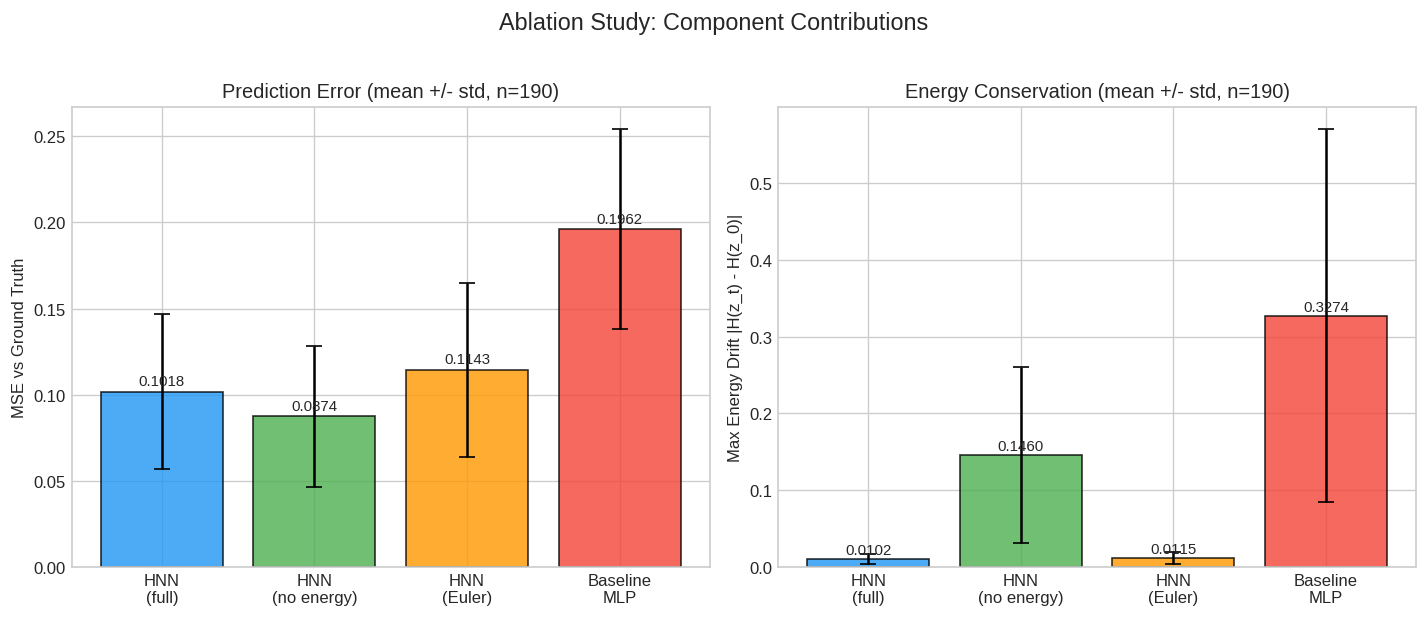


                                      SUMMARY TABLE                                       
                    (all metrics: mean +/- std over 190 test windows)                     
Model                                 MSE       Energy Drift     Params      ms/step
------------------------------------------------------------------------------------------
HNN (full)             0.1018 +/- 0.0452  0.0102 +/- 0.0065     919,041      2.73
HNN (no energy)        0.0874 +/- 0.0409  0.1460 +/- 0.1149     919,041       N/A
HNN (Euler)            0.1143 +/- 0.0504  0.0115 +/- 0.0078     919,041      0.95
Baseline MLP           0.1962 +/- 0.0581  0.3274 +/- 0.2435   1,312,768      0.15
------------------------------------------------------------------------------------------
HNN vs Baseline: 1.9x lower MSE, 32.2x lower energy drift
Learned dt: 1.1669
HNN inference cost: 18.5x baseline (leapfrog requires 3 gradient passes/step)

Model statistics:
  HNN params: 919,041
  Baseline params: 1,312,7

In [ ]:
# Evaluation plots and baseline comparison.
# Baseline uses multi-step rollout loss to match HNN training.

import matplotlib.pyplot as plt
import time

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

EVAL_HORIZON = CONFIG['window_size'] - 1  # 15 steps
EXTENDED_HORIZON = 50

# Baseline MLP

class BaselineMLP(nn.Module):
    """Direct z_{t+1} = f(z_t) predictor."""
    def __init__(self, latent_dim=1024, hidden_dims=[512, 512]):
        super().__init__()
        layers = []
        in_dim = latent_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ReLU())
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, latent_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        return self.net(z)

    def rollout(self, z0, n_steps):
        trajectory = [z0]
        z = z0
        for _ in range(n_steps):
            z = self.forward(z)
            trajectory.append(z)
        return torch.stack(trajectory, dim=1)


torch.manual_seed(SEED)
baseline = BaselineMLP(latent_dim=CONFIG['latent_dim']).to(device)
baseline_optimizer = torch.optim.AdamW(baseline.parameters(), lr=1e-3, weight_decay=1e-5)
baseline_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    baseline_optimizer, T_max=NUM_EPOCHS, eta_min=1e-5
)

BASELINE_EPOCHS = NUM_EPOCHS
print(f"Training baseline MLP with multi-step rollout loss ({BASELINE_EPOCHS} epochs)...")
print(f"  AdamW (lr=1e-3, wd=1e-5), cosine schedule, grad clip 1.0")
baseline.train()
for epoch in range(1, BASELINE_EPOCHS + 1):
    epoch_loss = 0
    n_batches = 0
    for batch in train_loader:
        batch = batch.to(device)
        B, T, D = batch.shape
        z_init = batch[:, 0, :]
        z_target = batch[:, 1:, :]

        z_pred = baseline.rollout(z_init, n_steps=T-1)[:, 1:, :]
        loss = F.mse_loss(z_pred, z_target)

        baseline_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(baseline.parameters(), max_norm=1.0)
        baseline_optimizer.step()
        epoch_loss += loss.item()
        n_batches += 1

    baseline_scheduler.step()
    if epoch % 10 == 0 or epoch == 1:
        print(f"  Epoch {epoch}/{BASELINE_EPOCHS}, Loss: {epoch_loss/n_batches:.4f}")

baseline.eval()

# Check for baseline collapse (near-zero step sizes)
test_sample = next(iter(test_loader))[0:1].to(device)
z_start = test_sample[:, 0, :]

with torch.no_grad():
    baseline_traj_full = baseline.rollout(z_start, n_steps=EXTENDED_HORIZON).squeeze(0)
    baseline_mean_step = torch.norm(
        baseline_traj_full[1:] - baseline_traj_full[:-1], dim=-1
    ).mean().item()

with torch.enable_grad():
    z_in = z_start.clone().requires_grad_(True)
    hnn_traj_full = integrator.rollout(z_in, n_steps=EXTENDED_HORIZON).squeeze(0).detach()

hnn_mean_step = torch.norm(
    hnn_traj_full[1:] - hnn_traj_full[:-1], dim=-1
).mean().item()

print(f"\nMean step size in latent space:")
print(f"  HNN (leapfrog):  {hnn_mean_step:.4f}")
print(f"  Baseline MLP:    {baseline_mean_step:.4f}")
if baseline_mean_step < 0.01:
    print("  >>> Baseline may have collapsed -- near-zero steps make its energy metrics meaningless.")

# Full test-set evaluation (all 4 models)
print("\nEvaluating all models on full test set...")

metrics_hnn = evaluate_model(integrator, 'hnn', hnn)
metrics_baseline = evaluate_model(baseline, 'baseline', hnn)

hnn_ne, integ_ne = ABLATION_MODELS['hnn_no_energy']
metrics_no_energy = evaluate_model(integ_ne, 'hnn', hnn_ne)

hnn_eu, integ_eu = ABLATION_MODELS['hnn_euler']
metrics_euler = evaluate_model(integ_eu, 'hnn', hnn_eu)

n_test = metrics_hnn['n_samples']
print(f"  {n_test} test windows")

# Inference timing
print("\nTiming 15-step rollout inference...")
z_bench = torch.randn(1, CONFIG['latent_dim'], device=device)
N_WARMUP = 10
N_TIMED = 100

def time_model(model_or_integ, model_type, label):
    for _ in range(N_WARMUP):
        if model_type == 'hnn':
            with torch.enable_grad():
                _ = model_or_integ.rollout(z_bench.requires_grad_(True), n_steps=EVAL_HORIZON)
        else:
            with torch.no_grad():
                _ = model_or_integ.rollout(z_bench, n_steps=EVAL_HORIZON)
        if torch.cuda.is_available():
            torch.cuda.synchronize()

    times = []
    for _ in range(N_TIMED):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        t0 = time.perf_counter()
        if model_type == 'hnn':
            with torch.enable_grad():
                _ = model_or_integ.rollout(z_bench.requires_grad_(True), n_steps=EVAL_HORIZON)
        else:
            with torch.no_grad():
                _ = model_or_integ.rollout(z_bench, n_steps=EVAL_HORIZON)
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        times.append((time.perf_counter() - t0) * 1000)

    return np.mean(times), np.std(times)

time_hnn_mean, time_hnn_std = time_model(integrator, 'hnn', 'HNN (leapfrog)')
time_euler_mean, time_euler_std = time_model(integ_eu, 'hnn', 'HNN (Euler)')
time_baseline_mean, time_baseline_std = time_model(baseline, 'baseline', 'Baseline MLP')

print(f"  HNN (leapfrog): {time_hnn_mean:.2f} +/- {time_hnn_std:.2f} ms "
      f"({time_hnn_mean/EVAL_HORIZON:.2f} ms/step)")
print(f"  HNN (Euler):    {time_euler_mean:.2f} +/- {time_euler_std:.2f} ms "
      f"({time_euler_mean/EVAL_HORIZON:.2f} ms/step)")
print(f"  Baseline MLP:   {time_baseline_mean:.2f} +/- {time_baseline_std:.2f} ms "
      f"({time_baseline_mean/EVAL_HORIZON:.2f} ms/step)")
print(f"  HNN/Baseline ratio: {time_hnn_mean/time_baseline_mean:.1f}x")
print(f"  (HNN needs enable_grad at inference for Hamilton's eqs)")

# Plot 1: Energy conservation
print("\nPlot 1: Energy conservation...")

with torch.no_grad():
    energies_ext = hnn(hnn_traj_full).squeeze(-1).cpu().numpy()

fig1, (ax1a, ax1b) = plt.subplots(1, 2, figsize=(14, 4))

timesteps_train = np.arange(EVAL_HORIZON + 1)
E0 = energies_ext[0]
ax1a.plot(timesteps_train, energies_ext[:EVAL_HORIZON+1], 'b-', linewidth=2, label='H(z_t)')
ax1a.axhline(y=E0, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label=f'H(z_0) = {E0:.4f}')
ax1a.fill_between(timesteps_train, E0, energies_ext[:EVAL_HORIZON+1], alpha=0.2, color='blue')
ax1a.set_xlabel('Timestep')
ax1a.set_ylabel('Hamiltonian H(q, p)')
ax1a.set_title(f'Energy Conservation: {EVAL_HORIZON}-Step (Training Horizon)')
ax1a.legend(loc='upper right')
drift_train = np.abs(energies_ext[:EVAL_HORIZON+1] - E0)
ax1a.text(0.02, 0.98,
         f'Mean drift: {drift_train.mean():.6f}\nMax drift: {drift_train.max():.6f}\nStd: {drift_train.std():.6f}',
         transform=ax1a.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=9)

timesteps_ext = np.arange(EXTENDED_HORIZON + 1)
ax1b.plot(timesteps_ext, energies_ext, 'b-', linewidth=2, label='H(z_t)')
ax1b.axhline(y=E0, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label=f'H(z_0) = {E0:.4f}')
ax1b.axvline(x=EVAL_HORIZON, color='green', linestyle=':', alpha=0.5, label=f'Train horizon ({EVAL_HORIZON})')
ax1b.fill_between(timesteps_ext, E0, energies_ext, alpha=0.2, color='blue')
ax1b.set_xlabel('Timestep')
ax1b.set_ylabel('Hamiltonian H(q, p)')
ax1b.set_title(f'Energy Conservation: {EXTENDED_HORIZON}-Step (Extended)')
ax1b.legend(loc='upper right')
drift_ext = np.abs(energies_ext - E0)
ax1b.text(0.02, 0.98,
         f'Mean drift: {drift_ext.mean():.6f}\nMax drift: {drift_ext.max():.6f}\nStd: {drift_ext.std():.6f}',
         transform=ax1b.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=9)

plt.tight_layout()
plt.savefig('/content/plot1_energy_conservation.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot 2: Phase portrait
print("Plot 2: Phase portrait...")

traj_np = hnn_traj_full.cpu().numpy()
q_dim = traj_np.shape[1] // 2
q = traj_np[:, :q_dim]
p = traj_np[:, q_dim:]

fig2, axes = plt.subplots(2, 4, figsize=(14, 7))

for i in range(4):
    ax = axes[0, i]
    ax.plot(q[:, i], p[:, i], 'b-', linewidth=1, alpha=0.7)
    ax.scatter(q[0, i], p[0, i], c='green', s=100, marker='o', zorder=5, label='Start')
    ax.scatter(q[-1, i], p[-1, i], c='red', s=100, marker='x', zorder=5, label='End')
    ax.set_xlabel(f'$q_{{{i}}}$')
    ax.set_ylabel(f'$p_{{{i}}}$')
    ax.set_title(f'Phase Space: Dim {i}')
    if i == 0:
        ax.legend(fontsize=8)

for i in range(4):
    ax = axes[1, i]
    ax.plot(timesteps_ext, q[:, i], 'b-', linewidth=1.5, label=f'$q_{{{i}}}$')
    ax.plot(timesteps_ext, p[:, i], 'r--', linewidth=1.5, label=f'$p_{{{i}}}$')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Value')
    ax.set_title(f'Time Evolution: Dim {i}')
    ax.legend(fontsize=8)

plt.suptitle('Phase Space Dynamics in Learned Hamiltonian Latent Space', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('/content/plot2_phase_portrait.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot 3: HNN vs Baseline
print("Plot 3: HNN vs baseline...")

fig3, axes = plt.subplots(2, 2, figsize=(12, 10))

ax = axes[0, 0]
ts = np.arange(1, len(metrics_hnn['per_timestep_mse_mean']) + 1)

ax.plot(ts, metrics_hnn['per_timestep_mse_mean'], 'b-', linewidth=2, label='HNN (Hamiltonian)')
ax.fill_between(ts,
    metrics_hnn['per_timestep_mse_mean'] - metrics_hnn['per_timestep_mse_std'],
    metrics_hnn['per_timestep_mse_mean'] + metrics_hnn['per_timestep_mse_std'],
    alpha=0.2, color='blue')

ax.plot(ts, metrics_baseline['per_timestep_mse_mean'], 'r--', linewidth=2, label='Baseline MLP')
ax.fill_between(ts,
    metrics_baseline['per_timestep_mse_mean'] - metrics_baseline['per_timestep_mse_std'],
    metrics_baseline['per_timestep_mse_mean'] + metrics_baseline['per_timestep_mse_std'],
    alpha=0.2, color='red')

ax.set_xlabel('Timestep')
ax.set_ylabel('MSE vs Ground Truth')
ax.set_title(f'Prediction Error ({EVAL_HORIZON}-Step, mean +/- 1 std)')
ax.legend()
ax.set_yscale('log')

ax = axes[0, 1]
ax.plot(ts, metrics_hnn['per_timestep_energy_mean'], 'b-', linewidth=2, label='HNN')
ax.fill_between(ts,
    metrics_hnn['per_timestep_energy_mean'] - metrics_hnn['per_timestep_energy_std'],
    metrics_hnn['per_timestep_energy_mean'] + metrics_hnn['per_timestep_energy_std'],
    alpha=0.2, color='blue')

ax.plot(ts, metrics_baseline['per_timestep_energy_mean'], 'r--', linewidth=2, label='Baseline MLP')
ax.fill_between(ts,
    metrics_baseline['per_timestep_energy_mean'] - metrics_baseline['per_timestep_energy_std'],
    metrics_baseline['per_timestep_energy_mean'] + metrics_baseline['per_timestep_energy_std'],
    alpha=0.2, color='red')

ax.set_xlabel('Timestep')
ax.set_ylabel('Energy H(z)')
ax.set_title(f'Energy Evolution ({EVAL_HORIZON}-Step, mean +/- 1 std)')
ax.legend()

ax = axes[1, 0]
baseline_traj_np = baseline_traj_full.cpu().numpy()
hnn_traj_np = hnn_traj_full.cpu().numpy()
gt_for_comparison = test_sample[0].cpu().numpy()
max_t = min(EVAL_HORIZON + 1, gt_for_comparison.shape[0])

ax.plot(hnn_traj_np[:max_t, 0], hnn_traj_np[:max_t, 1], 'b-', linewidth=1.5, alpha=0.7, label='HNN')
ax.plot(baseline_traj_np[:max_t, 0], baseline_traj_np[:max_t, 1], 'r--', linewidth=1.5, alpha=0.7, label='Baseline')
ax.plot(gt_for_comparison[:max_t, 0], gt_for_comparison[:max_t, 1], 'g:', linewidth=2, alpha=0.7, label='Ground Truth')
ax.scatter([hnn_traj_np[0, 0]], [hnn_traj_np[0, 1]], c='black', s=100, marker='o', zorder=5, label='Start')
ax.set_xlabel('$z_0$')
ax.set_ylabel('$z_1$')
ax.set_title('Trajectory in Latent Space (dims 0-1)')
ax.legend()

ax = axes[1, 1]
epochs = range(1, len(TRAINING_HISTORY['train_loss']) + 1)
ax.plot(epochs, TRAINING_HISTORY['train_loss'], 'b-', linewidth=2, label='Train Loss')
ax.plot(epochs, TRAINING_HISTORY['test_mse'], 'r--', linewidth=2, label='Test MSE')
ax.plot(epochs, TRAINING_HISTORY['train_energy'], 'g:', linewidth=2, label='Energy Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training History')
ax.legend()
ax.set_yscale('log')

plt.suptitle('Hamiltonian Neural Network vs Baseline MLP', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('/content/plot3_hnn_vs_baseline.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot 4: Ablation bar chart
print("Plot 4: Ablation study...")

model_names = ['HNN\n(full)', 'HNN\n(no energy)', 'HNN\n(Euler)', 'Baseline\nMLP']
all_metrics = [metrics_hnn, metrics_no_energy, metrics_euler, metrics_baseline]
colors = ['#2196F3', '#4CAF50', '#FF9800', '#F44336']

fig4, (ax4a, ax4b) = plt.subplots(1, 2, figsize=(12, 5))

mse_means = [m['mse_mean'] for m in all_metrics]
mse_stds = [m['mse_std'] for m in all_metrics]
x = np.arange(len(model_names))
bars = ax4a.bar(x, mse_means, yerr=mse_stds, capsize=5, color=colors, alpha=0.8, edgecolor='black')
ax4a.set_xticks(x)
ax4a.set_xticklabels(model_names)
ax4a.set_ylabel('MSE vs Ground Truth')
ax4a.set_title(f'Prediction Error (mean +/- std, n={n_test})')
for bar, val in zip(bars, mse_means):
    ax4a.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
              f'{val:.4f}', ha='center', va='bottom', fontsize=9)

drift_means = [m['drift_mean'] for m in all_metrics]
drift_stds = [m['drift_std'] for m in all_metrics]
bars = ax4b.bar(x, drift_means, yerr=drift_stds, capsize=5, color=colors, alpha=0.8, edgecolor='black')
ax4b.set_xticks(x)
ax4b.set_xticklabels(model_names)
ax4b.set_ylabel('Max Energy Drift |H(z_t) - H(z_0)|')
ax4b.set_title(f'Energy Conservation (mean +/- std, n={n_test})')
for bar, val in zip(bars, drift_means):
    ax4b.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
              f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Ablation Study: Component Contributions', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('/content/plot4_ablation.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary table
print("\n" + "="*90)
print(f"{'SUMMARY TABLE':^90}")
print(f"{'(all metrics: mean +/- std over ' + str(n_test) + ' test windows)':^90}")
print("="*90)
print(f"{'Model':<22} {'MSE':>18} {'Energy Drift':>18} {'Params':>10} {'ms/step':>12}")
print("-"*90)

rows = [
    ("HNN (full)", metrics_hnn, sum(p.numel() for p in hnn.parameters()), time_hnn_mean/EVAL_HORIZON),
    ("HNN (no energy)", metrics_no_energy, sum(p.numel() for p in hnn_no_energy.parameters()), None),
    ("HNN (Euler)", metrics_euler, sum(p.numel() for p in hnn_euler.parameters()), time_euler_mean/EVAL_HORIZON),
    ("Baseline MLP", metrics_baseline, sum(p.numel() for p in baseline.parameters()), time_baseline_mean/EVAL_HORIZON),
]
for name, m, params, ms_step in rows:
    ms_str = f"{ms_step:.2f}" if ms_step is not None else "N/A"
    print(f"{name:<22} {m['mse_mean']:.4f} +/- {m['mse_std']:.4f}  "
          f"{m['drift_mean']:.4f} +/- {m['drift_std']:.4f}  "
          f"{params:>10,}  {ms_str:>8}")

print("-"*90)
if metrics_baseline['mse_mean'] > 0:
    mse_ratio = metrics_baseline['mse_mean'] / metrics_hnn['mse_mean']
    drift_ratio = metrics_baseline['drift_mean'] / metrics_hnn['drift_mean']
    print(f"HNN vs Baseline: {mse_ratio:.1f}x lower MSE, {drift_ratio:.1f}x lower energy drift")
print(f"Learned dt: {integrator.dt.item():.4f}")
print(f"HNN inference cost: {time_hnn_mean/time_baseline_mean:.1f}x baseline (leapfrog needs 3 grad passes/step)")

print(f"\nModel statistics:")
print(f"  HNN params: {sum(p.numel() for p in hnn.parameters()):,}")
print(f"  Baseline params: {sum(p.numel() for p in baseline.parameters()):,}")
print(f"\nTraining summary:")
print(f"  Final train loss: {TRAINING_HISTORY['train_loss'][-1]:.4f}")
print(f"  Best test MSE: {min(TRAINING_HISTORY['test_mse']):.4f}")

print(f"\nFigures saved to /content/plot{{1,2,3,4}}_*.png")